In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor

C:\Users\aryav\AppData\Local\Temp\ipykernel_18688\692232756.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [23]:
data = pd.read_csv("data_onehot_x.csv", index_col=0)
data = data.query("num_romantic_involvements != 0")

X = data.drop("longest_relationship_months", axis=1)
y = data["longest_relationship_months"]

In [24]:
X, y

(     is_transfer  commute  minor  is_stem   gpa  club_general  \
 1              0        0      1        1  3.72             1   
 2              0        0      1        1  3.70             1   
 3              0        0      0        1  4.00             1   
 4              0        0      0        1   NaN             1   
 5              0        1      0        1  3.90             1   
 ..           ...      ...    ...      ...   ...           ...   
 99             0        1      0        1  3.30             1   
 103            0        1      0        1  3.40             1   
 106            0        1      1        1  3.30             1   
 108            0        1      0        1   NaN             1   
 109            0        0      0        1  3.70             1   
 
      club_professional  club_recreational  club_athletic  club_cultural  ...  \
 1                    1                  0              0              0  ...   
 2                    1                  0  

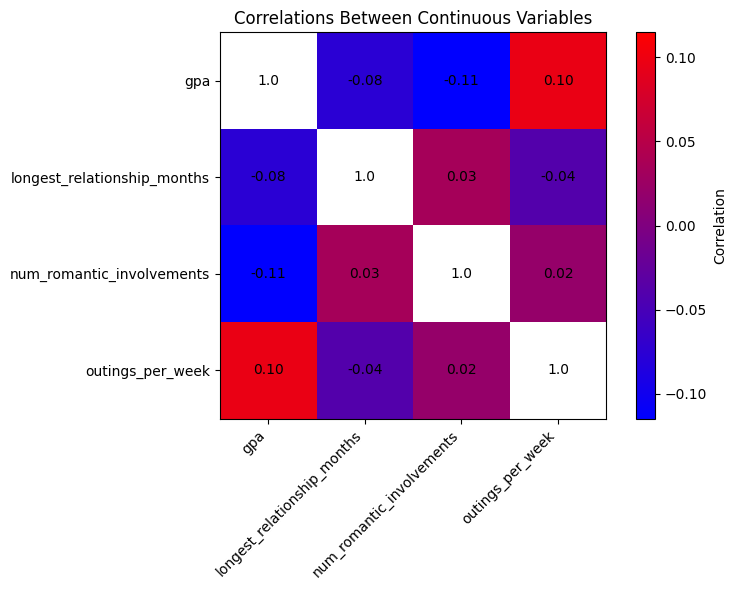

In [25]:
corr_matrix = data[["gpa", "longest_relationship_months", "num_romantic_involvements", "outings_per_week"]].corr().replace(1, np.nan)
range_endpoint = max(np.abs(corr_matrix.min().min()), np.abs(corr_matrix.max().max()))

plt.figure(figsize=(8, 6))

colors_list = [(0, 0, 1), (1, 0, 0)]
custom = LinearSegmentedColormap.from_list("fire_colors", colors_list, N=1000)
plt.imshow(corr_matrix, cmap=custom, vmin=-range_endpoint, vmax=range_endpoint)

plt.colorbar(label='Correlation')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Correlations Between Continuous Variables")
# Annotate with correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.index)):
        if np.isnan(corr_matrix.iloc[i, j]): 
            plt.text(j, i, f"1.0", ha="center", va="center", color="w" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black")
            continue
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="w" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black")
plt.tight_layout()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X.fillna(0), y, test_size=0.1
)

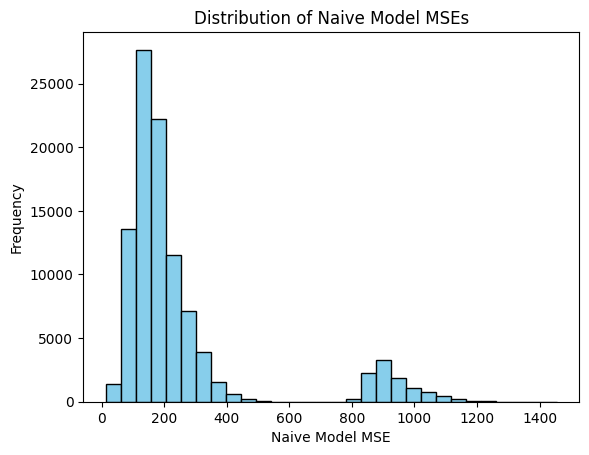

In [ ]:
naive_MSE = []

for x in range(100000):
    X_train, X_test, y_train, y_test = train_test_split(
        X.fillna(0), y, test_size=0.1
    )
    # Could add distributions for MSEs of the different models
    naive_pred = [y_train.mean()] * len(y_test)
    naive_MSE += [mean_squared_error(y_test, naive_pred)]

naive_MSE = np.array(naive_MSE)
plt.hist(naive_MSE, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Naive Model MSE')
plt.ylabel('Frequency')
plt.title('Distribution of Naive Model MSEs')
plt.show()

In [ ]:
supports = np.zeros(X.shape[1])
for x in range(25):
    X_train, X_test, y_train, y_test = train_test_split(
        X.fillna(0), y, test_size=0.1
    )
    model = LinearRegression()
    sfs = SequentialFeatureSelector(model, direction="backward", n_features_to_select=10)
    sfs.fit(X_train, y_train)
    supports += sfs.get_support().astype(int)

support_mask = np.array([False] * X.shape[1])
support_mask[(supports).argsort()[:10]] = np.array([True] * 10)
restricted_X = X[X.columns[support_mask]]
restricted_X

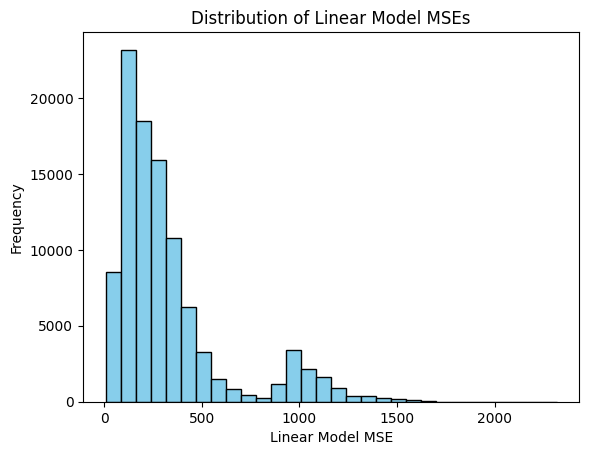

In [ ]:
coef_dist = []
linear_MSE = []
for x in range(100000):
    restricted_X_train, restricted_X_test, y_train, y_test = train_test_split(
        restricted_X.fillna(0), y, test_size=0.1
    )
    # Could add distributions for MSEs of the different models
    model = LinearRegression()
    model.fit(restricted_X_train, y_train)
    linear_pred = model.predict(restricted_X_test)
    linear_MSE += [mean_squared_error(y_test, linear_pred)]
    coef_dist += model.coef_

coef_dist = np.array(coef_dist)
linear_MSE = np.array(linear_MSE)
plt.hist(linear_MSE, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Linear Model MSE')
plt.ylabel('Frequency')
plt.title('Distribution of Linear Model MSEs')
plt.show()

In [68]:
coef_dist

array([ 4.41802798,  1.97550191, -3.04620364, ..., -5.16893292,
       -3.08328535, -5.77291043])

In [ ]:
coef_matrix = coef_dist.reshape((100000, 10))

array([ 5.16689782,  3.38611349, -1.97992265, -3.52761486, -3.5611062 ,
        7.97737689, 11.66712691, -5.59432428, -3.34398295, -6.06158721])

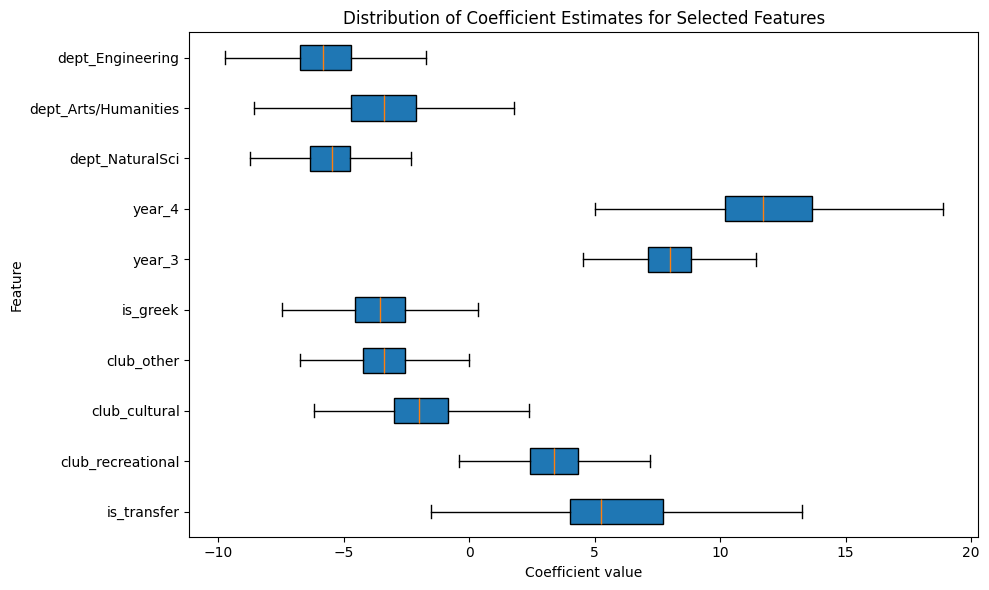

In [89]:
plt.figure(figsize=(10,6))
plt.boxplot(coef_matrix, showfliers=False, vert=False, patch_artist=True)
plt.yticks(
    ticks=np.arange(1, num_coefs+1), 
    labels=restricted_X.columns, 
)
plt.ylabel('Feature')
plt.xlabel('Coefficient value')
plt.title('Distribution of Coefficient Estimates for Selected Features')
plt.tight_layout()
plt.show()